In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import product
from DataExploration.BitbrainsUtils import load_VM, plot_timeSeries

import warnings
warnings.filterwarnings('ignore')


# Load data

In [3]:
# Load data
VM = load_VM('541.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]

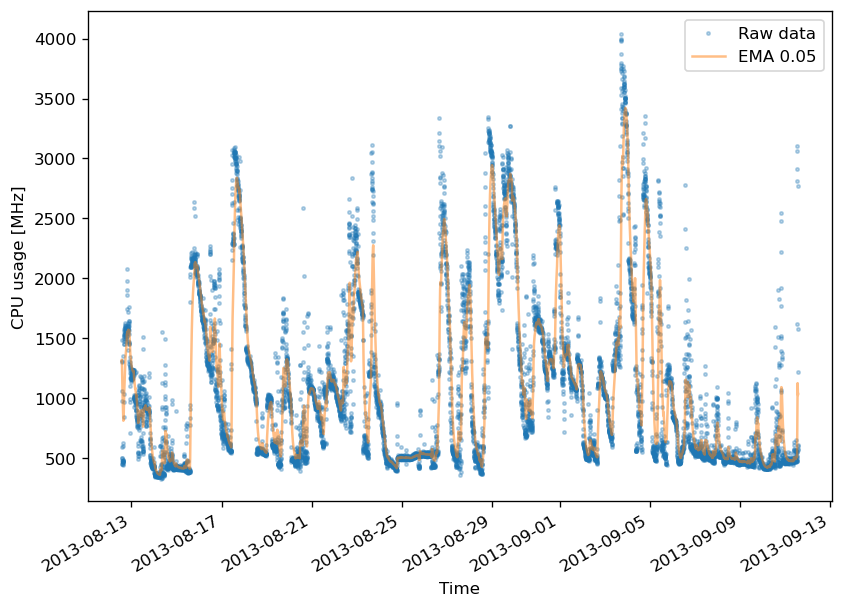

In [4]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

Series looks stationary both in mean and variance

# Stationary test

In [4]:
ad_fuller_result = adfuller(df)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.4084477366242085
p-value: 7.239938577200652e-11


p-value < 0.05 => reject Ho => stationary in mean

# ACF & PACF

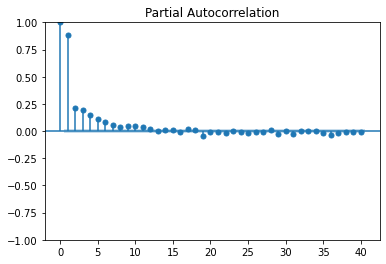

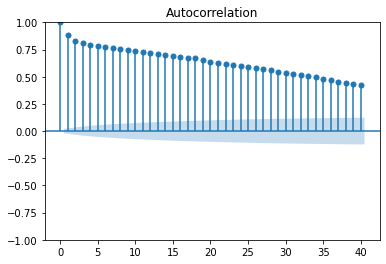

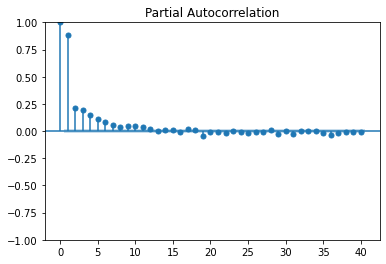

In [5]:
plot_acf(df)
plot_pacf(df)

# Seasonality

In [6]:
df_diff = df.diff(288)
df_diff = df_diff.dropna(axis=0)

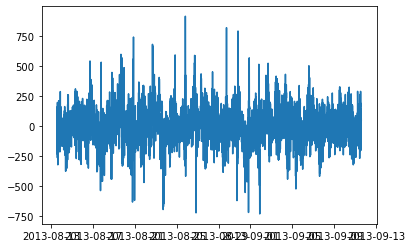

In [7]:
plt.plot(df_diff)

In [8]:
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.645242095527859
p-value: 1.406397971947852e-23


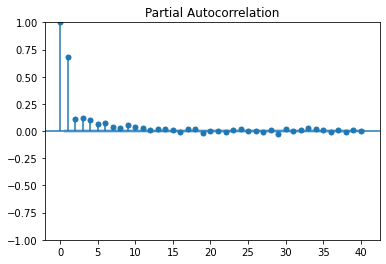

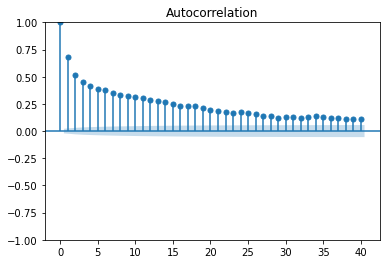

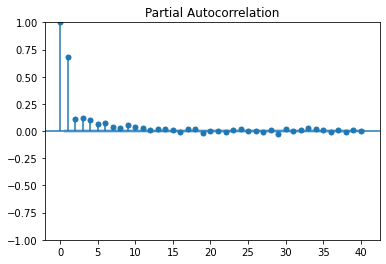

In [9]:
plot_acf(df_diff)
plot_pacf(df_diff)

In [10]:
def split_data(df: pd.DataFrame, training: float = 0.9, validation: float = 0, test: float = 0.3):
    n = len(df)
    df_copy = df.copy()
    train_df = df_copy[0:int(n * training)]
    val_df = df_copy[int(n * training):int(n * (training + validation))]
    test_df = df_copy[int(n * (training + validation)):]
    return train_df, val_df, test_df

In [11]:
train_df, val_df, test_df = split_data(df)

In [12]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 288
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, d, D, s, train_df)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
model = SARIMAX(train_df, order=(3, 0, 1), seasonal_order=(3, 0, 1, 288)).fit()
print(model.summary())

# Auto ARIMA

## Train test split

In [5]:
def split_data(df: pd.DataFrame, training: float = 0.9, validation: float = 0, test: float = 0.3):
    n = len(df)
    df_copy = df.copy()
    train_df = df_copy[0:int(n * training)]
    val_df = df_copy[int(n * training):int(n * (training + validation))]
    test_df = df_copy[int(n * (training + validation)):]
    return train_df, val_df, test_df

In [6]:
train_df, val_df, test_df = split_data(df)

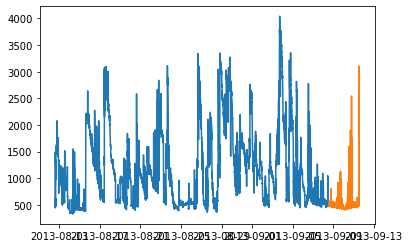

In [7]:
plt.plot(train_df)
plt.plot(test_df)

In [32]:
arima_model = auto_arima(train_df, start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         d=0,
                         m=288, seasonal=True,
                         start_P=0,
                         D=0,
                         start_Q=0,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True,
                         n_jobs=-1)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[288] intercept   : AIC=88957.685, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[288] intercept   : AIC=101639.381, Time=0.04 sec


KeyboardInterrupt: 

In [13]:
arima_model = auto_arima(train_df, start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         d=0,
                         seasonal=False,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True,
                         n_jobs=-1)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=89069.608, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=120044.869, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=90010.542, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=111022.359, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=88624.622, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=88616.543, Time=1.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=88618.372, Time=1.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=88618.916, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=88617.775, Time=0.51 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=88620.281, Time=0.62 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=88575.069, Time=2.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept  

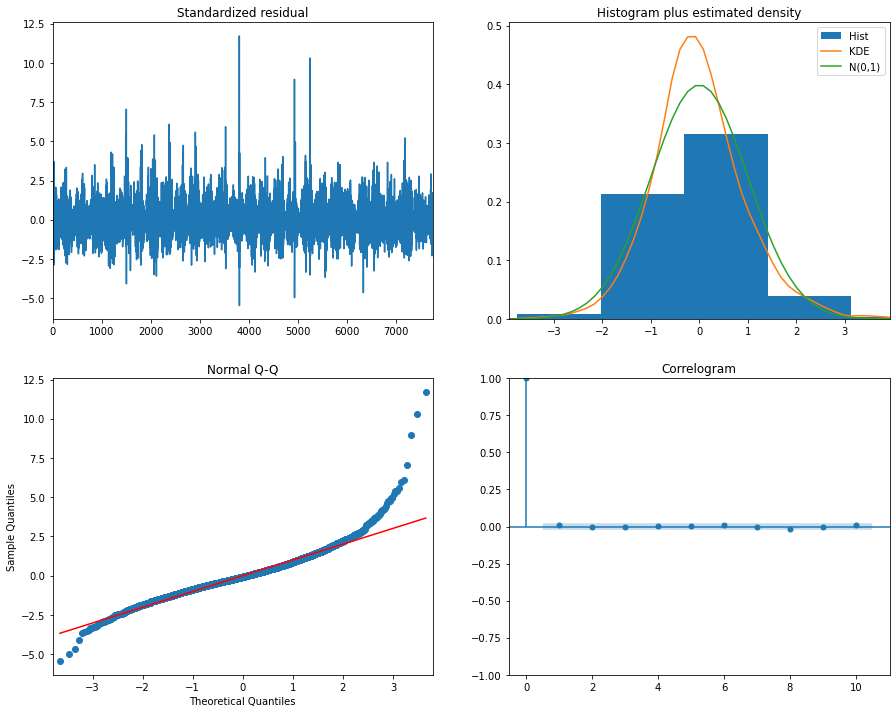

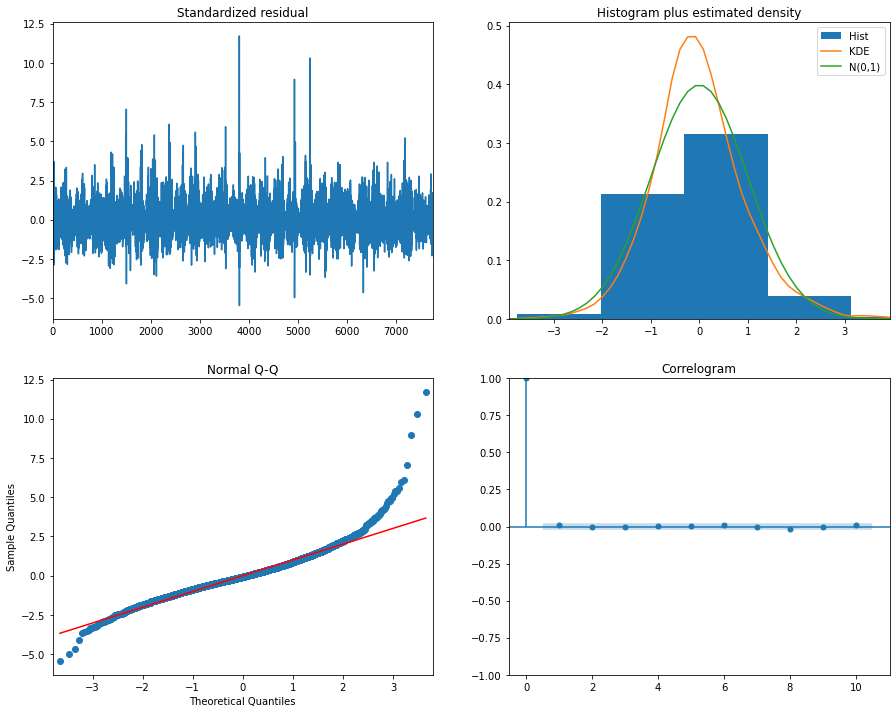

In [14]:
arima_model.plot_diagnostics(figsize=(15,12))

In [15]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 862), index=test_df.index)
prediction.columns = ['CPU usage [MHZ']
prediction

,CPU usage [MHZ
Timestamp [ms],
2013-09-08 13:50:00,570.385470
2013-09-08 13:55:00,554.058821
2013-09-08 14:00:00,548.839097
2013-09-08 14:05:00,547.358820
2013-09-08 14:10:00,546.931169
...,...
2013-09-11 13:15:00,541.322123
2013-09-11 13:20:00,541.322117
2013-09-11 13:25:00,541.322112


In [ ]:
%matplotlib tk
plt.figure(figsize=(8,5))
# plt.plot(train_df, label="Training")
plt.plot(test_df,label="Test")
plt.plot (prediction, label="Predicted")
plt.legend()
plt.show()

# Exponential smoothing

In [8]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from DataExploration.BitbrainsUtils import mase

In [9]:
def split_data(df: pd.DataFrame, training: float = 0.9, validation: float = 0, test: float = 0.3):
    n = len(df)
    df_copy = df.copy()
    train_df = df_copy[0:int(n * training)]
    val_df = df_copy[int(n * training):int(n * (training + validation))]
    test_df = df_copy[int(n * (training + validation)):]
    return train_df, val_df, test_df


train_df, val_df, test_df = split_data(df)

In [6]:
fit1 = SimpleExpSmoothing(train_df).fit(smoothing_level=0.2, optimized=False)

In [7]:
len(test_df)

862

In [10]:
def baseline_prediction(model, train_df, test_df, horizon=1):
    pred = []
    for i in range(0, len(test_df), horizon):
        training = pd.concat([train_df, test_df.iloc[:i,:]])
        fit = model(training).fit()
        pred.append(fit.forecast(horizon))
    pred = np.reshape(pred, (-1,1))
    pred = pred[:len(test_df),:]
    pred_df = pd.DataFrame(data=np.array(pred), columns=['CPU usage [MHZ]'], index=test_df.index)
    return pred_df

In [11]:
model = SimpleExpSmoothing
pred = baseline_prediction(model, train_df, test_df, horizon=6)

In [12]:
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                   'linestyle': '',
                   'alpha': 0.5,
                   'markersize': 2,
                   'color': 'tab:orange'}

In [13]:
%matplotlib tk
plt.figure(dpi=150)
test_df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title('Baseline')
plt.grid()

In [15]:
def baseline_evaluate(test_df, pred, train_trf):
    y_true = np.array(test_df['CPU usage [MHZ]'])
    y_pred = np.array(pred['CPU usage [MHZ]'])
    y_train = np.array(train_trf.iloc[:, 0])
    metrics_dic = {'MAE': np.array(mean_absolute_error(y_true, y_pred)),
                   'MAPE': np.array(mean_absolute_percentage_error(y_true, y_pred)),
                   'RMSE': np.sqrt(np.array(mean_squared_error(y_true, y_pred))),
                   'MASE': mase(y_true, y_pred, y_train),
                   'train_time [s]': 'NaN',
                   'inference_time [s]': 'NaN',
                   'model_size [B]': 'NaN'
                   }
    metrics = pd.DataFrame.from_dict(metrics_dic, orient='index', columns=['Exponential Smoothing'])
    return metrics

In [16]:
metrics = baseline_evaluate(test_df, pred, train_df)

In [ ]:
# Simple exponential smoothing
fit1 = SimpleExpSmoothing(train_df).fit(smoothing_level=0.2, optimized=False)
# or automatically optimized
fit1 = SimpleExpSmoothing(train_df).fit()
# Holt's method